In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageDraw
import random
import cv2

## CAE using our custom data

In [3]:
class ImageDirDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # 获取指定目录下的所有图像文件路径
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 打开图像
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        # 因为ImageFolder默认返回(img, label)
        # 这里我们若无分类标签需求，可返回一个虚拟标签，比如0
        return img, 0
    
# ==== 修复后的 CorruptedDataset ====
class ChoppedDataset(Dataset):
    def __init__(self, dataset, transformA=None,transformB=None):
        self.dataset = dataset
        self.transformA = transformA
        self.transformB = transformB

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        if self.transformA:
            imgA = self.transformA(img)  # Transform 图像为 Tensor
        if self.transformB:
            imgB = self.transformB(img)  # Transform 图像为 Tensor
        return imgB, imgA  # 返回加Chop签名图像、原始签名图像

In [5]:
def generate_black_tone_rgb():
    """
    Generate RGB color close to black with a slight gray tone.
    """
    # Limit RGB values close to black, but allow slight deviation
    r = random.randint(60, 111)  # Red range
    g = random.randint(60, 111)  # Green range
    b = random.randint(60, 111)  # Blue range

    # Add constraint for gray balance to prevent color bias
    if abs(r - g) > 10 or abs(g - b) > 10 or abs(r - b) > 10:
        # If color deviates too much from black/gray, regenerate
        return generate_black_tone_rgb()

    return (r, g, b)

def resize_width(image, target_width):
    """
    Resize image to target width while maintaining aspect ratio.
    Accepts both file path and PIL Image.
    """
    if isinstance(image, str):
        image = Image.open(image)
    
    # Calculate new height maintaining aspect ratio
    width, height = image.size
    new_height = int((target_width * height) / width)

    # Resize image
    resized_image = image.resize((target_width, new_height), Image.LANCZOS)
    return resized_image

def pad_mask_randomly(mask, target_size=512, pad_val=0):
    """
    Pad a mask to a square with random vertical padding.
    
    :param mask: NumPy array mask
    :param target_size: Desired output size
    :param pad_val: Padding value
    :return: Padded mask
    """
    current_height, current_width = mask.shape

    # Compute total vertical padding needed
    vertical_padding = target_size - current_height
    
    # Randomly split padding between top and bottom
    top_padding = np.random.randint(0, vertical_padding + 1)
    bottom_padding = vertical_padding - top_padding
    
    # Pad the mask
    padded_mask = np.pad(mask, 
                         ((top_padding, bottom_padding), (0, 0)), 
                         mode='constant', 
                         constant_values=pad_val)
    return padded_mask

def pad_image(image, target_size=512, pad_axis="height", random_padding=True):
    """
    Pad image to target height or width, optionally adding randomness to alignment.

    :param image: NumPy array or PIL Image
    :param target_size: Desired target size for height or width
    :param pad_axis: "height" to pad vertically, "width" to pad horizontally
    :param random_padding: Whether to use random alignment for padding
    :return: Padded image
    """
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    height, width, _ = image.shape

    if pad_axis == "height":
        if height == target_size:
            return image
        max_offset = target_size - height
        padded_image = np.ones((target_size, width, 3), dtype=np.uint8) * 255
        if random_padding and max_offset > 0:
            offset = random.randint(0, max_offset)
        else:
            offset = max_offset // 2
        padded_image[offset:offset + height, :, :] = image
    elif pad_axis == "width":
        if width == target_size:
            return image
        max_offset = target_size - width
        padded_image = np.ones((height, target_size, 3), dtype=np.uint8) * 255
        if random_padding and max_offset > 0:
            offset = random.randint(0, max_offset)
        else:
            offset = max_offset // 2
        padded_image[:, offset:offset + width, :] = image
    else:
        raise ValueError("Invalid pad_axis. Use 'height' or 'width'.")
    
    return padded_image

def pad_image_height(image, target_height=512, random_padding=False):
    """
    Pad image to target height, optionally adding randomness to vertical alignment.

    :param image: NumPy array or PIL Image
    :param target_height: Desired output height
    :param random_padding: Whether to use random vertical alignment
    :return: Padded image
    """
    width, height = image.size
    if height == target_height:
        return image
    if height > target_height:
        return image.resize(((int)(width * target_height / height) , target_height), Image.LANCZOS)
    # Create white canvas
    padded_image = np.ones((target_height, width, 3), dtype=np.uint8) * 255

    # Calculate vertical offset
    max_offset = target_height - height
    if random_padding and max_offset > 0:
        vertical_offset = random.randint(0, max_offset)
    else:
        vertical_offset = max_offset // 2  # Center if randomness is off or max_offset <= 0

    # Copy original image to the canvas at the determined vertical position
    padded_image[vertical_offset:vertical_offset + height, :, :] = np.array(image)
    
    return Image.fromarray(padded_image)

def get_sign_mask(image, target_height, bg_color_range=([0, 0, 0], [255, 255, 200])):
    """
    Get sign mask with background replacement.
    
    :param image: Input image path or PIL Image
    :param bg_color_range: Color range for background
    :param target_height: Target mask height
    :return: Processed mask
    """
    img = replace_bg(image)
    mask = get_bg_mask(img, bg_color_range)
    return pad_mask_randomly(mask, target_size=target_height)

def get_bg_mask(image, bg_color_range, chop_name=None):
    """
    Create a mask for background colors.
    
    :param image: Input image
    :param bg_color_range: Background color range
    :param chop_name: Optional name (not used in this implementation)
    :return: Binary mask
    """
    # Convert to NumPy array if it's a PIL Image
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # Convert to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define color range
    lower_blue = np.array(bg_color_range[0])
    upper_blue = np.array(bg_color_range[1])
    
    # Create mask
    blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
    return blue_mask

def rotate_image_with_background(image, angle_range=9):
    """
    Rotate image with random angle and white background.
    
    :param image: Input image
    :param angle_range: Maximum rotation angle
    :return: Rotated image
    """
    # Convert to PIL Image if it's a NumPy array
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    # Get image dimensions
    width, height = image.size
    
    # Generate random angle
    angle = random.uniform(-angle_range, angle_range)
    
    # Rotate image with white background
    rotated_image = image.rotate(angle, resample=Image.BICUBIC, fillcolor=(255, 255, 255))
    
    # If rotated image is larger, crop to original size
    if rotated_image.size != (width, height):
        # Calculate crop box to center the image
        left = (rotated_image.width - width) // 2
        top = (rotated_image.height - height) // 2
        right = left + width
        bottom = top + height
        
        rotated_image = rotated_image.crop((left, top, right, bottom))
    
    return rotated_image

def replace_bg(img):
    """
    Replace background with white.
    
    :param img: Input image path or PIL Image
    :return: Image with replaced background
    """
    if isinstance(img, str):
        img = Image.open(img)
    
    # Convert to NumPy for processing
    img_array = np.array(img)
    
    # Define background color range
    lower_bg_color = np.array([240, 240, 240], dtype=np.uint8)
    upper_bg_color = np.array([254, 254, 254], dtype=np.uint8)

    # Create mask for background
    bg_mask = ((img_array >= lower_bg_color) & (img_array <= upper_bg_color)).all(axis=2)
    
    # Replace background with white
    img_array[bg_mask] = [255, 255, 255]
    return Image.fromarray(img_array)


def threshold_image(img_arr):
    thresh = threshold_otsu(img_arr)
    return np.where(img_arr > thresh, 255, 0)


def convert_image_into_B_domain_v1(sign_image):
    """
    Convert image into B domain with chop overlay.
    
    :param sign_image_path: Path to signature image
    :return: Processed image
    """
    target_size = 256
    # Read signature image
    sign_img_resized = resize_width(sign_image, target_size)
    
    # Choose and prepare chop image
    chop_img_no = random.choice(['aifin', 'jinetic', 'kaizen', 'metro', 'suixin'])
    chop_img = resize_width(Image.open(f'chop_{chop_img_no}.png'), target_size)
    chop_img_array = rotate_image_with_background(chop_img)
    
    # Convert chop image to NumPy if it's not already
    if isinstance(chop_img_array, Image.Image):
        chop_img_array = np.array(chop_img_array)
    
    # Pad chop image if needed
    if chop_img_array.shape[0] < sign_img_resized.size[1]:
        chop_img_array = pad_image_height(chop_img_array, target_height=sign_img_resized.size[1])
    
    # Get sign mask
    sign_mask = get_sign_mask(sign_img_resized, target_height=chop_img_array.shape[0])
    
    # Replace sign area with black tone
    chop_img_array[sign_mask != 0] = generate_black_tone_rgb()
    
    return Image.fromarray(chop_img_array)


def merge_images_with_white_bg(image1, image2):
    """
    合并两张白色背景的图片，将非白色的图案叠加。
    
    :param image1: 第一张 PIL 图像
    :param image2: 第二张 PIL 图像
    :return: 合并后的 PIL 图像
    """
    # 确保两张图片大小一致
    if image1.size != image2.size:
        raise ValueError("Images must have the same size!")
    
    # 转为 NumPy 数组
    arr1 = np.array(image1)
    arr2 = np.array(image2)
    
    # 创建掩码：白色像素定义为 [255, 255, 255]
    mask1 = ~((arr1[:, :, :3] == [255, 255, 255]).all(axis=-1))
    mask2 = ~((arr2[:, :, :3] == [255, 255, 255]).all(axis=-1))
    
    # 创建结果图像数组，默认全白
    merged_array = np.ones_like(arr1, dtype=np.uint8) * 255
    
    # 合并非白色像素（图案）
    merged_array[mask1] = arr1[mask1]  # 保留第一张图的非白像素
    merged_array[mask2] = arr2[mask2]  # 叠加第二张图的非白像素
    
    return Image.fromarray(merged_array)

def convert_image_into_B_domain_v2(sign_image):
    """
    Convert image into B domain with chop overlay.
    
    :param sign_image_path: Path to signature image
    :return: Processed image
    """
    target_size = 256
    # Read signature image
    sign_img_resized = resize_width(replace_bg(sign_image), target_size)
    # Choose and prepare chop image
    chop_img_no = random.choice(['aifin', 'aifin-rd', 'jinetic', 'kaizen', 'metro', 'suixin'])
    chop_img = resize_width(replace_bg(Image.open(f'chop_{chop_img_no}.png')), target_size)

    common_height = max(sign_img_resized.size[1], chop_img.size[1])
    sign_img_resized = pad_image_height(sign_img_resized, common_height, random_padding=True)
    chop_img = pad_image_height(chop_img, common_height, random_padding=True)
    chop_img = rotate_image_with_background(chop_img)
    # sign_img_array = np.array(sign_img_resized, dtype=np.float32)
    # chop_img_array = rotate_image_with_background(chop_img)
    # # 合并图片 (这里使用像素平均值)
    # merged_array = ((sign_img_array + chop_img_array) / 2).astype(np.uint8)
    # # 转回PIL图像
    # merged_image = Image.fromarray(merged_array)    
    merged_image = merge_images_with_white_bg(chop_img, sign_img_resized)
    return merged_image

In [6]:
class SignatureToBlackTransform:
    """
    将带有白色背景和灰色签名的图片转变为纯黑色字迹
    """
    def __call__(self, img):
        # 确保输入是 PIL 图像
        if not isinstance(img, Image.Image):
            raise TypeError("Input image must be a PIL Image.")

        # 转换为 numpy 数组
        img_np = np.array(img)

        # 确保图像是 RGB 模式
        if len(img_np.shape) == 2:  # 如果是灰度图
            img_np = np.stack([img_np] * 3, axis=-1)

        # 定义白色背景和灰色范围
        lower_gray = np.array([200, 200, 200], dtype=np.uint8)  # 灰色及以上
        upper_gray = np.array([255, 255, 255], dtype=np.uint8)  # 纯白色

        # 创建灰色掩码
        gray_mask = np.all((img_np >= lower_gray) & (img_np <= upper_gray), axis=-1)

        # 将灰色部分变为黑色，其他保持不变
        img_np[~gray_mask] = [0, 0, 0]  # 非灰色部分变黑
        img_np[gray_mask] = [255, 255, 255]  # 灰色部分变白

        # 转换回 PIL 图像
        return Image.fromarray(img_np)

class ReplaceBackground:
    def __call__(self, img):
        return replace_bg(img)

class PaddToSquare:
    def __init__(self, size=256):
        """
        初始化填充为正方形的目标大小。
        :param size: 目标正方形的边长
        """
        self.size = size

    def __call__(self, img):
        """
        调整图像填充为正方形。
        :param img: 输入的 PIL.Image
        :return: 填充后的 PIL.Image
        """
        if not isinstance(img, Image.Image):
            raise TypeError("Input must be a PIL.Image")

        width, height = img.size

        # 如果图像已经是正方形且满足目标大小，直接返回
        if width == self.size and height == self.size:
            return img

        # 如果图像的较大边超过目标大小，先等比例缩放
        if max(width, height) > self.size:
            scaling_factor = self.size / max(width, height)
            new_width = int(width * scaling_factor)
            new_height = int(height * scaling_factor)
            img = img.resize((new_width, new_height))

        # 获取缩放后的新尺寸
        width, height = img.size

        # 创建目标大小的空白图像（白色背景）
        padded_img = Image.new("RGB", (self.size, self.size), (255, 255, 255))

        # 计算粘贴位置
        left = (self.size - width) // 2
        top = (self.size - height) // 2

        # 将缩放后的图像粘贴到空白图像上
        padded_img.paste(img, (left, top))

        return padded_img
    
class TransformToB:
    def __call__(self, img):
        return convert_image_into_B_domain_v2(img)

img_size=(256,256)
transformB = transforms.Compose([
    TransformToB(),
    PaddToSquare(size=256),
    transforms.ToTensor()  # 转换为 Tensor
])

transformA = transforms.Compose([
    ReplaceBackground(),  # 替换背景颜色
    SignatureToBlackTransform(),
    PaddToSquare(size=256),
    transforms.Grayscale(),
    transforms.ToTensor()  # 转换为 Tensor
])

In [ ]:
dataset = ImageDirDataset(root_dir='sign_data_images', transform=None)
chopped_dataset = ChoppedDataset(dataset=dataset, transformA=transformA, transformB=transformB)
dataloader = DataLoader(chopped_dataset, batch_size=16, shuffle=True)

In [ ]:
def visualize_sample(dataset, num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))
    for i in range(num_samples):
        corrupted_img, original_img = dataset[i]
        
        # Convert tensors to NumPy arrays for visualization
        # Make sure to denormalize and move from [0,1] to [0,255] if needed
        corrupted_img_np = corrupted_img.permute(1, 2, 0).numpy()
        original_img_np = original_img.permute(1, 2, 0).numpy()

        # Clip values to ensure they are in [0, 1] range for imshow
        corrupted_img_np = np.clip(corrupted_img_np, 0, 1)
        original_img_np = np.clip(original_img_np, 0, 1)

        # Display each row of images
        axs[i, 0].imshow(corrupted_img_np)
        axs[i, 0].set_title("Corrupted Image")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(original_img_np)
        axs[i, 1].set_title("Original Image")
        axs[i, 1].axis("off")    
    plt.tight_layout()
    plt.show()

visualize_sample(chopped_dataset, num_samples=2)

## UNetCAE Model

In [7]:
class UNetCAE(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNetCAE, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        # Decoder
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._block(feature * 2, feature))

        self.bottleneck = self._block(features[-1], features[-1] * 2)
        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](x)

        return self.final_layer(x)

    @staticmethod
    def _block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

In [ ]:
def gray_to_rgb(image):
    return image.repeat(1, 3, 1, 1)

# 定义感知损失 (Perceptual Loss)
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:16]  # 提取 VGG 的前 16 层
        self.vgg = vgg.eval()  # 设置为评估模式
        for param in self.vgg.parameters():
            param.requires_grad = False  # 冻结 VGG 的参数

    def forward(self, x, y):
        if x.size(1) == 1:
            x = gray_to_rgb(x)
        if y.size(1) == 1:
            y = gray_to_rgb(y)
        # 确保输入范围与 VGG 的训练范围一致
        x = F.normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        y = F.normalize(y, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        x_features = self.vgg(x)
        y_features = self.vgg(y)
        return nn.functional.mse_loss(x_features, y_features)

In [ ]:
# ==== 4. 初始化模型、损失函数和优化器 ====
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = UNetCAE(out_channels=1).to(device)

lambda_mse = 1.0
lambda_perceptual = 0.1

criterion_mse = nn.MSELoss()
criterion_perceptual = PerceptualLoss().to(device)

def combined_loss(output, target):
    mse_loss = criterion_mse(output, target)
    perceptual_loss = criterion_perceptual(output, target)
    return lambda_mse * mse_loss + lambda_perceptual * perceptual_loss

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# ==== 5. 训练循环 ====
epochs = 20
output_dir = "inpainting_output"
os.makedirs(output_dir, exist_ok=True)

for epoch in range(3):
    model.train()
    epoch_loss = 0

    for corrupted_imgs, original_imgs in dataloader:
        corrupted_imgs = corrupted_imgs.to(device)
        original_imgs = original_imgs.to(device)
        
        # 前向传播
        reconstructed = model(corrupted_imgs)
        loss = combined_loss(reconstructed, original_imgs)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    
    # 保存修复结果用于可视化
    if (epoch + 1) % 3 == 0:  # 每 5 个 epoch 保存一次
        save_image(corrupted_imgs, os.path.join(output_dir, f"corrupted_epoch_{epoch+1}.png"))
        save_image(reconstructed, os.path.join(output_dir, f"reconstructed_epoch_{epoch+1}.png"))
        save_image(original_imgs, os.path.join(output_dir, f"original_epoch_{epoch+1}.png"))

torch.Size([1, 3, 468, 998])


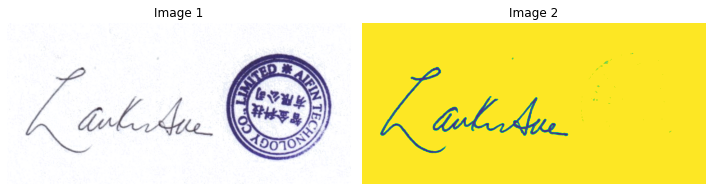

In [24]:
import torch
from torchvision.utils import save_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load('CAE-epoch40.pth', map_location=torch.device('cuda:0'))
model.eval()

img_path = "testdata/test5.jpg"  # 替换为你的图片路径
img = Image.open(img_path).convert("RGB")

transformTest = transforms.Compose([
    ReplaceBackground(),  # 替换背景颜色
#     transforms.Resize(256),  # 调整大小
#     PaddToSquare(size=256),
    transforms.ToTensor()  # 转换为 Tensor
])

input_tensor = transformTest(img).unsqueeze(0).to(device)
print(input_tensor.shape)

with torch.no_grad():
    reconstructed = model(input_tensor)
    squeezed_tensor = reconstructed.to('cpu').squeeze()
    squeezed_tensor = (squeezed_tensor - squeezed_tensor.min()) / (squeezed_tensor.max() - squeezed_tensor.min()) * 255
    squeezed_tensor = squeezed_tensor.byte()
    img_array = squeezed_tensor.numpy()
    
    save_image(input_tensor, "test_corrupted.png")
    
    # save_image(reconstructed, "test_reconstructed.png")
    threshold = 190
    filtered_array = np.where(img_array < threshold, img_array, 255)  # 较黑的像素保留，其他设置为白色
    # 转换回 PIL 图像
    filtered_img = Image.fromarray(filtered_array.astype("uint8"))
    filtered_img.save("test_reconstructed.png")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 行，2 列的子图

# 显示第一张图片
axs[0].imshow(Image.open("test_corrupted.png"))
axs[0].set_title("Image 1")
axs[0].axis("off")  # 关闭坐标轴

# 显示第二张图片
axs[1].imshow((Image.open("test_reconstructed.png")))
axs[1].set_title("Image 2")
axs[1].axis("off")  # 关闭坐标轴

# 调整布局并显示
plt.tight_layout()
plt.show()


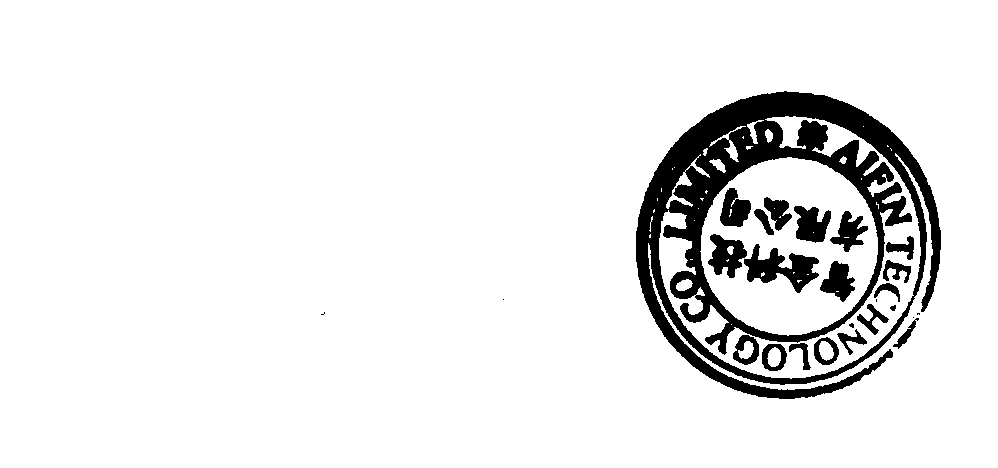

In [25]:
from PIL import Image
import numpy as np

# 加载两张图片
image_a_path = "test_corrupted.png"  # 包含签名和印章的图片 (A)
image_b_path = "test_reconstructed.png"  # 仅有签名的图片 (B)

# 打开图片并转换为灰度图
image_a = Image.open(image_a_path).convert("L")  # A 转为灰度图
image_b = Image.open(image_b_path).convert("L")  # B 转为灰度图

# 对 A 和 B 图像进行二值化处理
threshold_a = 180  # A 图像的二值化阈值
binary_a = np.array(image_a) < threshold_a  # A 的二值图，黑色部分为 True
threshold_b = 128  # B 图像的二值化阈值
binary_b = np.array(image_b) < threshold_b  # B 的二值图，黑色部分为 True

# 生成遮罩 mask，只保留 A 中不属于 B 的部分
mask = np.logical_and(binary_a, ~binary_b)  # 在 A 中有但不在 B 中的部分

# 将 mask 应用于 A，背景设为白色
result_array = np.where(mask, 0, 255)  # 黑色部分 (0) 保留，其他变为白色 (255)

# 转换回 PIL 图像
result_image = Image.fromarray(result_array.astype("uint8"))

# 显示和保存结果
result_image.show()

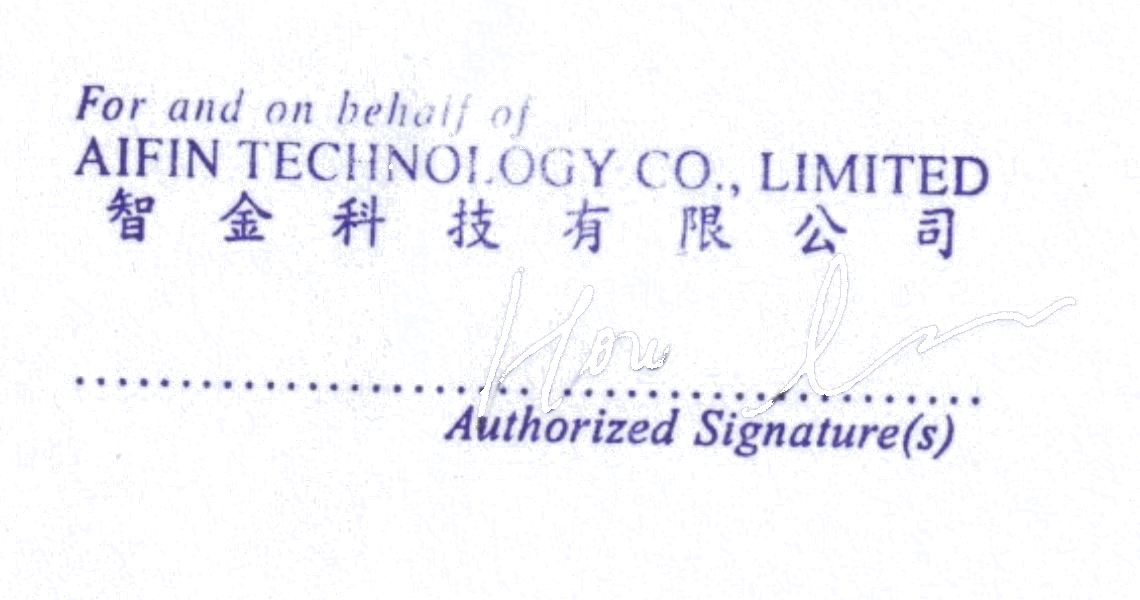

In [18]:
from PIL import Image
import numpy as np

# 加载两张图片
image_a_path = "test_corrupted.png"  # 包含签名和印章的图片 (A)
image_b_path = "test_reconstructed.png"  # 仅有签名的图片 (B)

# 打开图片并转换为灰度图
image_a = Image.open(image_a_path).convert("RGB")
image_a = replace_bg(image_a)
image_b = Image.open(image_b_path).convert("L")  # 灰度图，用于生成二值化 mask

# 将签名图片 B 转换为二值图像，生成遮罩 mask
threshold = 128  # 二值化阈值，调整该值以适应不同图片
binary_mask = np.array(image_b) < threshold  # 签名部分为 True，其余为 False

# 将遮罩扩展为 RGB 通道
mask_rgb = np.stack([binary_mask] * 3, axis=-1)  # Shape: (H, W, 3)

# 将 A 中被 mask 覆盖的部分设置为白色
array_a = np.array(image_a)
result_array = np.where(mask_rgb, [255, 255, 255], array_a)  # Mask 覆盖的部分变白

# 转换回 PIL 图像
result_image = Image.fromarray(result_array.astype("uint8"))

# 显示和保存结果
result_image.show()

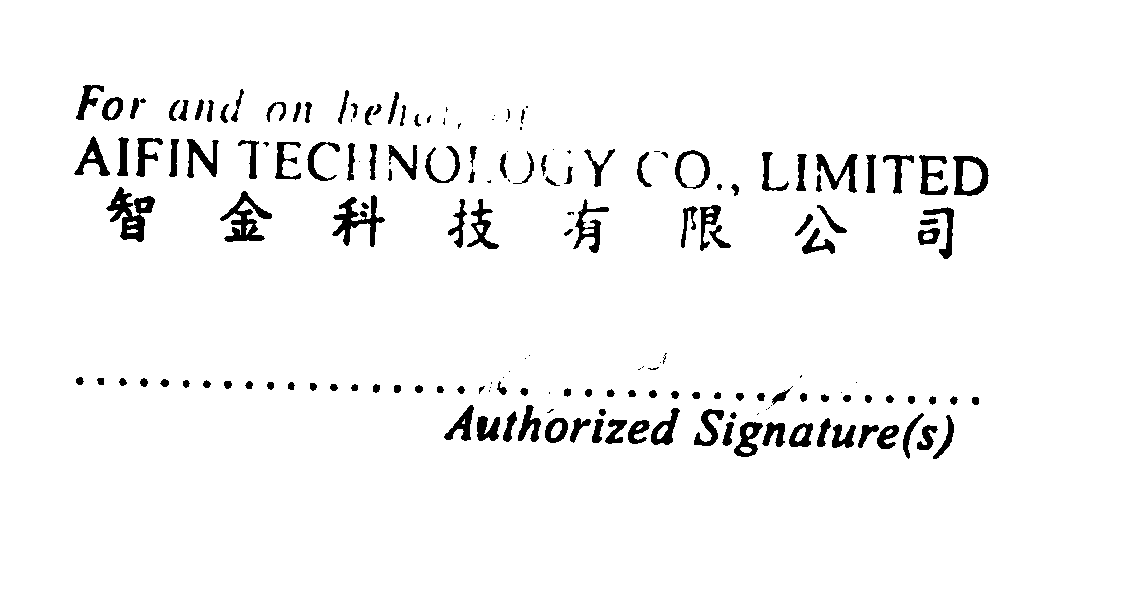